In [ ]:
import pandas as pd
import numpy as np

file_path = "/content/elektrik_veri_hashed.xlsx"

df_tahsilat = pd.read_excel(file_path, 'Tahsilat')
df_tahsilat_1 = pd.read_excel(file_path, 'Tahsilat 1')
df_tahakkuk = pd.read_excel(file_path, 'Tahakkuk') # Hamamözü
df_tahakkuk_1 = pd.read_excel(file_path, 'Tahakkuk 1') # Gümüşhacıköy
df_tahakkuk_2 = pd.read_excel(file_path, 'Tahakkuk 2') # Göynücek

Problem Tanımı: İlçeler arası tüketim farklılıklarına hangi faktörler sebep oluyor

Hipotez : Hamamözü'nde sanayi ve tarımsal sulama aboneliği az olduğu için yaz aylarında Gümüşhacıköy ve Göynücek kadar keskin bir artış görülmemektedir

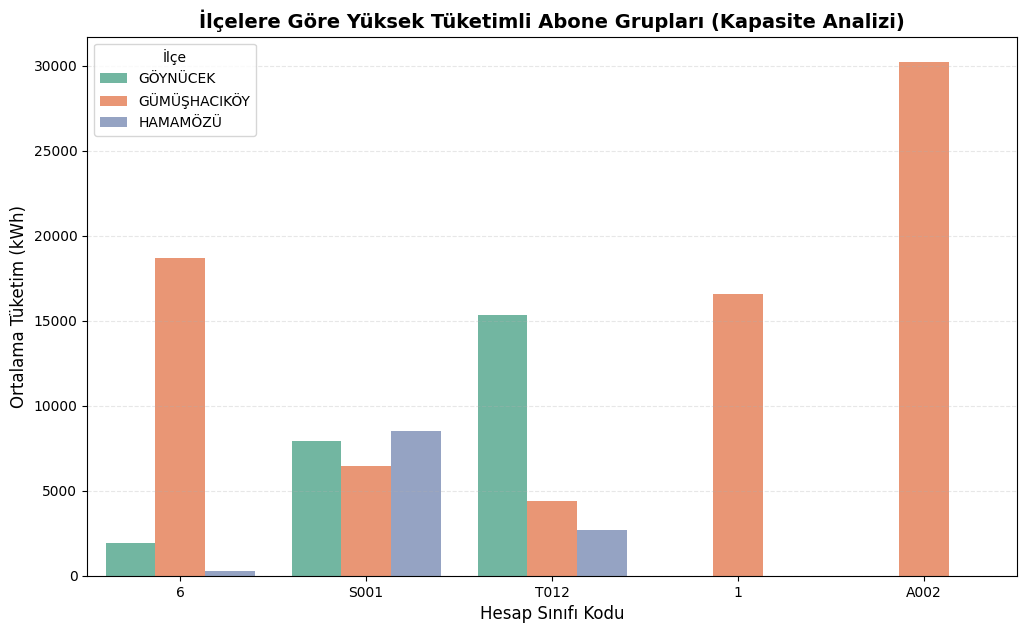


--- En Çok Tüketen Grupların İlçe Bazlı Ortalamaları ---
ilce              GÖYNÜCEK  GÜMÜŞHACIKÖY     HAMAMÖZÜ
hesap_sinifi                                         
1                      NaN  16594.174857          NaN
6              1928.708750  18698.155229   279.680000
A002                   NaN  30203.431220          NaN
S001           7923.987273   6429.819897  8512.881739
T012          15319.909189   4411.984559  2678.049500


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_tahakkuk_toplam = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2], ignore_index=True)

# 1. Veri Tiplerini ve İsimleri Standartlaştır (Hata almamak için)
df_tahakkuk_toplam['hesap_sinifi'] = df_tahakkuk_toplam['hesap_sinifi'].astype(str).str.strip().str.upper()
df_tahakkuk_toplam['ilce'] = df_tahakkuk_toplam['ilce'].astype(str).str.strip().str.upper()

# 2. En yüksek ortalama tüketime sahip ilk 5 sınıfı bulalım
# (Bunlar genellikle Sanayi ve Tarımsal Sulama kodlarıdır)
top_5_sinif = df_tahakkuk_toplam.groupby('hesap_sinifi')['kwh'].mean().sort_values(ascending=False).head(5).index
df_plot = df_tahakkuk_toplam[df_tahakkuk_toplam['hesap_sinifi'].isin(top_5_sinif)]

# 3. İlçe ve Hesap Sınıfı bazında ortalama tüketimi hesapla
analiz_df = df_plot.groupby(['ilce', 'hesap_sinifi'])['kwh'].mean().reset_index()

# 4. Görselleştirme
plt.figure(figsize=(12, 7))
sns.barplot(data=analiz_df, x='hesap_sinifi', y='kwh', hue='ilce', palette='Set2')

plt.title('İlçelere Göre Yüksek Tüketimli Abone Grupları (Kapasite Analizi)', fontsize=14, fontweight='bold')
plt.xlabel('Hesap Sınıfı Kodu', fontsize=12)
plt.ylabel('Ortalama Tüketim (kWh)', fontsize=12)
plt.legend(title='İlçe')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

# 5. Bulguyu desteklemek için sayısal özet
print("\n--- En Çok Tüketen Grupların İlçe Bazlı Ortalamaları ---")
print(analiz_df.pivot(index='hesap_sinifi', columns='ilce', values='kwh'))

Bulgular ve Yorumlar:

Gümüşhacıköy ve Göynücek'te tüketimi Temmuz ayında "yukarı fırlatan" büyük ölçekli kullanıcılar varken, Hamamözü bu "itici güçten" yoksundur.

Hamamözü: Tüketimi daha çok birbirine yakın değerlerde olan küçük bir gruptan oluşuyor (Mesken ağırlıklı). Bu yüzden toplam tüketim grafiği yıl boyunca sakin ve tahmin edilebilir seyrediyor.

Diğerleri: Portföylerinde hem küçük evler hem de devasa işletmeler var. Yazın bu işletmeler devreye girdiğinde, ortalama tüketim Hamamözü'nün hayal edemeyeceği seviyelere çıkıyor.

Önerilen Strateji : Hamamözü'ndeki elektrik altyapısı (trafo ve hatlar) yıl boyunca stabil bir yüke maruz kalırken, Gümüşhacıköy ve Göynücek'te altyapı Temmuz-Ağustos aylarında ekstrem bir stres altındadır. Banka/Şirket olarak kredi veya yatırım planlarken, Hamamözü için 'rutin bakım', diğer iki ilçe için ise 'mevsimsel kapasite artırımı' finansmanı önceliklendirilmelidir.

# Müşteri Segmentasyonu

/tmp/ipython-input-922918669.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=segment_df, x='Segment', palette='magma')


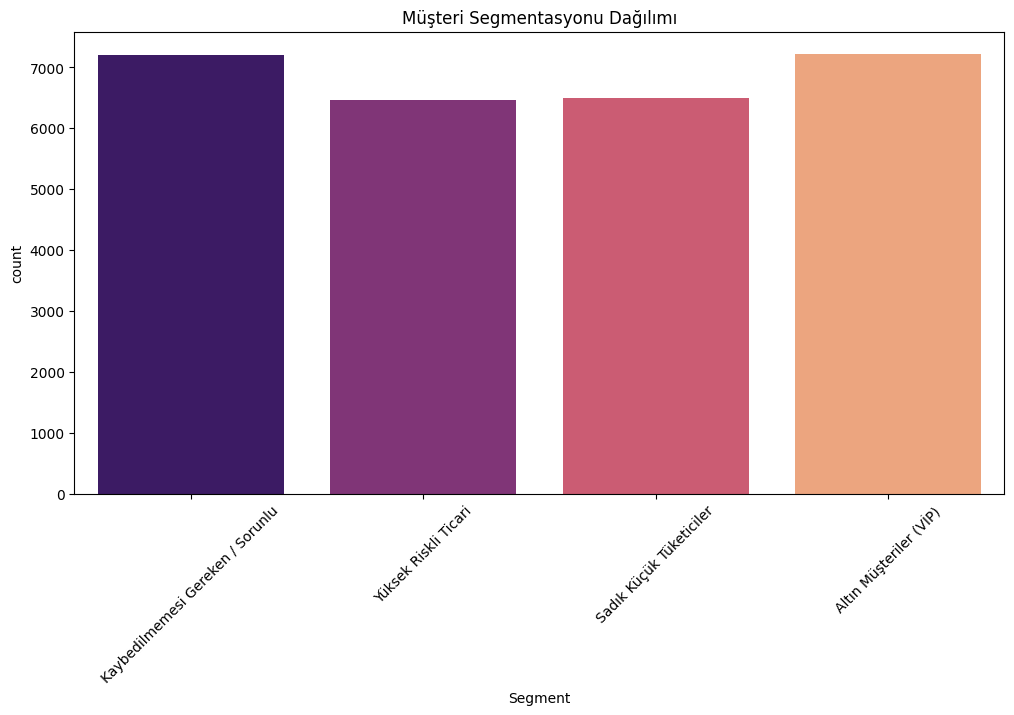

In [ ]:
# 1. Tüketim Gücü (Tahakkuk verisinden)
musteri_tuketim = df_tahakkuk_toplam.groupby('sozlesme_hesap_no')['kwh'].mean().reset_index()

# 2. Ödeme Performansı (Tahsilat 1 verisinden gecikme sütunlarını kontrol edelim)
gecikme_kolonlari = [col for col in df_tahsilat_1.columns if 'Son Ödeme (' in col]
df_tahsilat_1['toplam_gecikme_sayisi'] = df_tahsilat_1[gecikme_kolonlari].notna().sum(axis=1)
musteri_odeme = df_tahsilat_1.groupby('Söz.hsp.(bağımsız)')['toplam_gecikme_sayisi'].mean().reset_index()

# 3. Verileri Birleştirme
segment_df = pd.merge(musteri_tuketim, musteri_odeme, left_on='sozlesme_hesap_no', right_on='Söz.hsp.(bağımsız)')

# 4. Basit Segmentasyon Mantığı (Median değerlerine göre)
tuketim_esigi = segment_df['kwh'].median()
gecikme_esigi = segment_df['toplam_gecikme_sayisi'].median()

def segmentlere_ayir(row):
    if row['kwh'] >= tuketim_esigi and row['toplam_gecikme_sayisi'] <= gecikme_esigi:
        return 'Altın Müşteriler (VİP)'
    elif row['kwh'] >= tuketim_esigi and row['toplam_gecikme_sayisi'] > gecikme_esigi:
        return 'Yüksek Riskli Ticari'
    elif row['kwh'] < tuketim_esigi and row['toplam_gecikme_sayisi'] <= gecikme_esigi:
        return 'Sadık Küçük Tüketiciler'
    else:
        return 'Kaybedilmemesi Gereken / Sorunlu'

segment_df['Segment'] = segment_df.apply(segmentlere_ayir, axis=1)


plt.figure(figsize=(12, 6))
sns.countplot(data=segment_df, x='Segment', palette='magma')
plt.title('Müşteri Segmentasyonu Dağılımı')
plt.xticks(rotation=45)
plt.show()

**Altın Müşteriler (VIP):**

Bu grup, gelirin ana kaynağını oluşturur. Hem yüksek tüketim yaparlar hem de nakit akışını bozmazlar.

**Strateji:** Bu müşterilere özel "Enerji Danışmanlığı" hizmeti verilebilir. Banka tarafında ise, nakit akışları çok düzenli olduğu için en düşük faizli "İşletme Geliştirme Kredileri" bu gruba proaktif olarak sunulmalıdır.

**Yüksek Riskli Ticari**

Bu grupta muhtemelen Tarımsal Sulama (TA01) ve bazı sanayi kuruluşları bulunuyor. Tüketimleri çok yüksek ancak ödemeleri "hasat" veya "ihracat" bekledikleri için gecikmeli.

**Strateji:** Bu grup için standart son ödeme tarihleri yerine "Dönemsel Ödeme Planları" geliştirilmelidir. Örneğin, Temmuz ayındaki devasa faturasını Ekim ayında (hasat sonrası) ödeyebileceği bir yapılandırma kredi ürünü olarak sunulabilir.

**Sadık Küçük Tüketiciler**

Sayıca en kalabalık ama tekil bazda getirisi en düşük gruptur (Genellikle Meskenler).

**Strateji :** Bu grup için operasyonel maliyetleri sıfırlamak gerekir. "Sadece Dijital Fatura" ve "Otomatik Ödeme Talimatı" karşılığında küçük indirimler veya banka puanları verilmelidir.

**Sorunlu/Kaybedilmemesi Gereken**

Tüketimi düşük olmasına rağmen sürekli gecikme yaşayan gruptur.

**Strateji:** Bu grup için "Ön Ödemeli Sayaç" (kontörlü elektrik gibi) bir seçenek olabilir. Ayrıca, borç birikmeden küçük taksitlerle ödeme imkanı sağlayan mikrokrediler tanımlanabilir.

**Sonuçta:** Yaptığımız analiz, enerji tüketiminin sadece teknik bir veri olmadığını, müşterinin ekonomik can damarını yansıttığını göstermiştir. Gümüşhacıköy'deki bir çiftçinin (Yüksek Riskli Ticari) ödeme gecikmesi bir 'temerrüt' değil, bir 'nakit döngüsü' sorunudur. Bu nedenle stratejimiz, cezalandırıcı faiz yerine, müşterinin iş döngüsüne uyumlu finansal çözümler sunmaktır.

# Tahsilat Performans Analizi

**Problem Tanımı:** Ödeme davranışlarını etkileyen faktörler nelerdir, hangi müşteri grupları risk oluşturuyor

/tmp/ipython-input-3448940079.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_analizi.head(10), x='Hesap Sınıfı', y='gecikme_orani', palette='Reds_r')


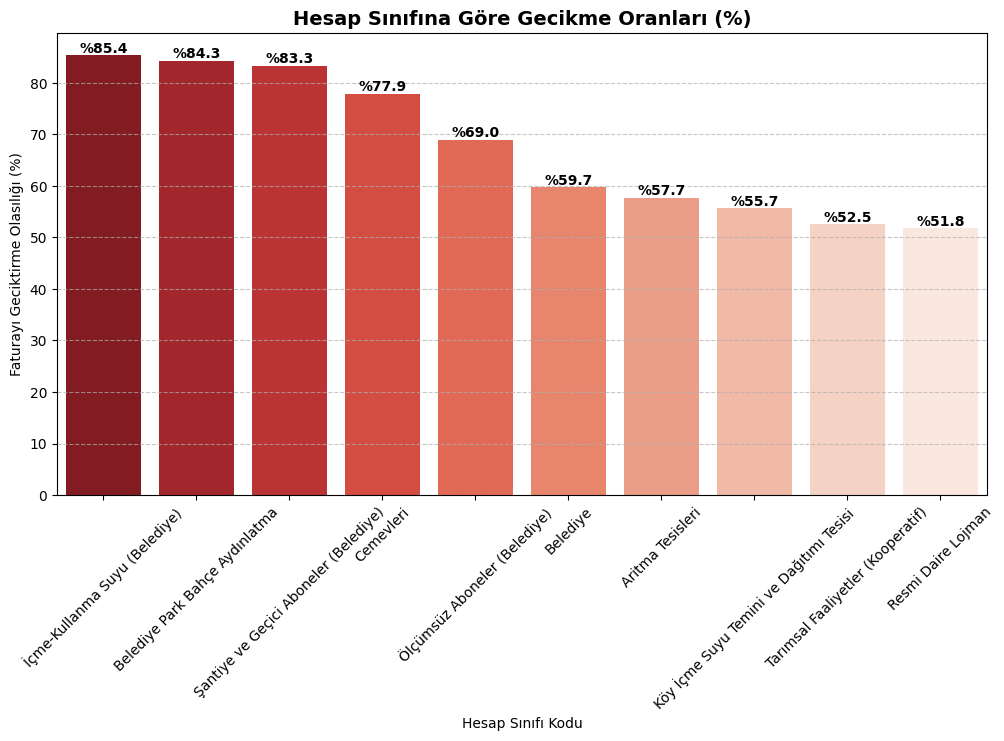


--- Gecikme Süreleri Dağılımı ---
Son Ödeme (10-20)      48281
Son Ödeme (6-10)       45708
Son Ödeme (20-30)      29005
Son Ödeme (30-60)      23030
Son Ödeme (2)          21664
Son Ödeme (1)          20902
Son Ödeme (3)          18893
Son Ödeme (4)          16995
Son Ödeme (5)           7323
Son Ödeme (60-90)       7184
Son Ödeme (180+)        4827
Son Ödeme (90-120)      3820
Son Ödeme (120-150)     2302
Son Ödeme (150-180)     1551
dtype: int64


In [ ]:

# 1. Veriyi Temizle ve Gruplandır
# Sütun isimlerini standartlaştırıyoruz
df_tahsilat_1.columns = df_tahsilat_1.columns.str.strip()

# Zamanında ve Gecikme Sütunlarını Tanımla
zamaninda_cols = ['Son Ödeme Tarihinden Önceki Tahsilat', 'Son Ödeme Tarihindeki Tahsilat']
gecikme_cols = [col for col in df_tahsilat_1.columns if 'Son Ödeme (' in col]

# 2. Risk Metriklerini Hesapla
# Satır bazında: Hiç gecikme var mı?
df_tahsilat_1['gecikme_var_mi'] = df_tahsilat_1[gecikme_cols].notna().any(axis=1).astype(int)

# Hesap Sınıfı bazında Gecikme Oranlarını hesapla
risk_analizi = df_tahsilat_1.groupby('Hesap Sınıfı').agg(
    toplam_kayit=('gecikme_var_mi', 'count'),
    geciken_kayit=('gecikme_var_mi', 'sum')
).reset_index()

risk_analizi['gecikme_orani'] = (risk_analizi['geciken_kayit'] / risk_analizi['toplam_kayit']) * 100
risk_analizi = risk_analizi.sort_values(by='gecikme_orani', ascending=False)

# 3. Görselleştirme: En Riskli Müşteri Grupları
plt.figure(figsize=(12, 6))
sns.barplot(data=risk_analizi.head(10), x='Hesap Sınıfı', y='gecikme_orani', palette='Reds_r')

plt.title('Hesap Sınıfına Göre Gecikme Oranları (%)', fontsize=14, fontweight='bold')
plt.ylabel('Faturayı Geciktirme Olasılığı (%)')
plt.xlabel('Hesap Sınıfı Kodu')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Oranları çubukların üzerine yaz
for i, val in enumerate(risk_analizi.head(10)['gecikme_orani']):
    plt.text(i, val + 0.5, f'%{val:.1f}', ha='center', fontweight='bold')

plt.show()

# 4. Gecikme Süresi Analizi (Hangi vade daha baskın?)
vade_dagilimi = df_tahsilat_1[gecikme_cols].notna().sum().sort_values(ascending=False)
print("\n--- Gecikme Süreleri Dağılımı ---")
print(vade_dagilimi)

**Bulgular:**

En yüksek gecikme oranına sahip kurumların belediye ve iştirakleri olduğu görünüyor. Özellikle içme ve kullanma suyu hesaplarınının en yüksek gecikmeye sahip olduğu açıkça ortada. Bunun sebebi olarak belediyenin halka sağladığı su imkanlarından alacağı fatura ücretlerinde yaşanan gecikmeler büyük ölçüde etkili olduğu söylenebilir.